In [1]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras.backend as K


2024-05-09 13:31:15.179888: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:31:15.219567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 13:31:15.219619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 13:31:15.220651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 13:31:15.226559: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:31:15.227066: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
parameter_data = pd.read_csv('../02_machine_learning/parameter_data_lead_time_also_FZ.csv')
#parameter_data.drop(columns=['airport_id'], inplace=True)
#parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [3]:
# # For analyzis in dataframe only

parameter_data['time'] = pd.to_datetime(parameter_data['time'])

# Sort the DataFrame by 'timestamp' in ascending order
# Shift the 'metar' column by one hour
parameter_data['metar_lead_1'] = parameter_data['metar'].shift(-1)

In [3]:
parameter_data = parameter_data[parameter_data['metartype'] != 'AUTO']

In [4]:
parameter_data['metartype'].unique()

array(['MANUAL', 'COR', 'SPECI'], dtype=object)

In [5]:
parameter_data = parameter_data.drop(columns=['airport_id'])

In [6]:
parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [7]:
parameter_data['airport_id']

10         0
11         0
12         0
13         0
14         0
          ..
555308    49
555309    49
555310    49
555311    49
555312    49
Name: airport_id, Length: 411933, dtype: int64

In [57]:
# Train test split
X_train, X_test = train_test_split(parameter_data, test_size = 0.2, random_state=9)

### Downsampling the occurrences of FALSE for contain_FZ

In [58]:
downsampling_percentage = 0.006

fz_majority = X_train[X_train['contain_FZ'] == False]
fz_minority = X_train[X_train['contain_FZ'] == True]

print(f'Size of majority: {fz_majority.shape}')
print(f'Size of minority: {fz_minority.shape}')

majority_size = int(len(fz_majority) * downsampling_percentage)

# Downsample the majority class to match the minority class
downsampled_majority = resample(fz_majority, replace=False, n_samples=majority_size, random_state=42)
print(f'Size of downsampled majority: {downsampled_majority.shape}')

# Combine the downsampled majority class with the original minority class
downsampled_X_train = pd.concat([downsampled_majority, fz_minority])

Size of majority: (327904, 127)
Size of minority: (1642, 127)
Size of downsampled majority: (1967, 127)


In [59]:
print(f'Size of downsampled training data: {X_train_downsampled.shape}')


Size of downsampled training data: (3154, 128)


In [10]:
X_train_downsampled = downsampled_X_train.drop(['contain_FZ'], axis=1)
X_train_fz = downsampled_X_train['contain_FZ']
y_train = downsampled_X_train[['contain_FZ_lead_1']]
y_test = X_test['contain_FZ_lead_1']
X_test_fz = X_test['contain_FZ']
#X_test = X_test.drop(['contain_FZ'], axis=1)

## F1-score 

In [11]:
def f1_score_calc(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Standardize features

In [12]:
data_params = ['air_temperature_0m', 'air_temperature_2m', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'fog_area_fraction', 'surface_air_pressure', 
               'air_pressure_at_sea_level', 'precipitation_amount_calculated',
              'air_temperature_pl_850', 'x_wind_pl_850', 'y_wind_pl_850', 'air_temperature_pl_925', 'x_wind_pl_925', 'y_wind_pl_925',
              'liquid_water_content_of_surface_snow']


In [13]:
data_params_lead_time = [f'{param}_lead_{lead_time}' for param in data_params for lead_time in range(1,2)]

In [14]:
data_params_lead_time

['air_temperature_0m_lead_1',
 'air_temperature_2m_lead_1',
 'relative_humidity_2m_lead_1',
 'x_wind_10m_lead_1',
 'y_wind_10m_lead_1',
 'fog_area_fraction_lead_1',
 'surface_air_pressure_lead_1',
 'air_pressure_at_sea_level_lead_1',
 'precipitation_amount_calculated_lead_1',
 'air_temperature_pl_850_lead_1',
 'x_wind_pl_850_lead_1',
 'y_wind_pl_850_lead_1',
 'air_temperature_pl_925_lead_1',
 'x_wind_pl_925_lead_1',
 'y_wind_pl_925_lead_1',
 'liquid_water_content_of_surface_snow_lead_1']

In [15]:
all_data_params = data_params + data_params_lead_time

In [16]:
scaler = StandardScaler()

X_train_downsampled[all_data_params] = scaler.fit_transform(X_train_downsampled[all_data_params])
X_test[all_data_params] = scaler.transform(X_test[all_data_params])

## Embedding layer for airport id

In [19]:
#num_airports = len(parameter_data_embed['airport_id'].unique())
num_airports = len(parameter_data['airport_id'].unique())
print(f'Number of airports: {num_airports}')
input_aid = Input(shape=(1,))
output_dim = 20

embedding_layer = Embedding(input_dim=num_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
flatten_airports = Flatten()(embedding_layer)

emb_cat = Reshape(target_shape=(output_dim,))(flatten_airports)

Number of airports: 50


## Model: ANN

In [28]:
l1_lambda = 0.002

#param_features_dim = Input(shape=(16,))

# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat])

dense_layer_1 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(concat)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dropout_1 = Dropout(0.2)(batch_norm_1)

dense_layer_2 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)

dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer_3)


#dense_layer_4 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(dense_layer_3)

#batch_norm_2 = BatchNormalization()(dense_layer_3)

#dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_2)
#batch_norm_3 = BatchNormalization()(dense_layer_3)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

# Output Layer
output_layer = Dense(units=1, activation='sigmoid')(batch_norm_3)
model = Model(inputs=[input_aid], outputs=output_layer)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_airport (Embeddi  (None, 1, 20)             1000      
 ng)                                                             
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 reshape (Reshape)           (None, 20)                0         
                                                                 
 concatenate_3 (Concatenate  (None, 20)                0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 64)                1344

In [30]:
# Compile the model
ml_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=ml_optimizer, metrics=[f1_score_calc])

In [31]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
history = model.fit([X_train_downsampled['airport_id']], y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=1, callbacks=early_stopping)

Epoch 1/100


/home/tonjek/.local/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


91/91 [==============================] - 1s 4ms/step - loss: 3.6014 - f1_score_calc: 0.4657 - val_loss: 3.8498 - val_f1_score_calc: 0.0000e+00
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 3.0653 - f1_score_calc: 0.4258 - val_loss: 3.6190 - val_f1_score_calc: 0.0000e+00
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 2.6839 - f1_score_calc: 0.4058 - val_loss: 3.3677 - val_f1_score_calc: 0.0000e+00
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 2.3676 - f1_score_calc: 0.3432 - val_loss: 3.0872 - val_f1_score_calc: 0.0000e+00
Epoch 5/100
91/91 [==============================] - 0s 2ms/step - loss: 2.0892 - f1_score_calc: 0.3689 - val_loss: 2.7916 - val_f1_score_calc: 0.0000e+00
Epoch 6/100
91/91 [==============================] - 0s 2ms/step - loss: 1.8484 - f1_score_calc: 0.3573 - val_loss: 2.4523 - val_f1_score_calc: 0.0000e+00
Epoch 7/100
91/91 [==============================] - 0s 2ms/step - loss: 1.6262 - 

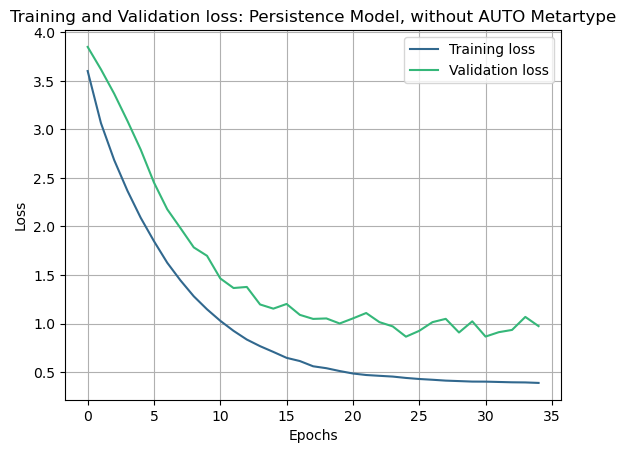

In [33]:
history = pd.DataFrame(history.history)
cmap_loss_val = sns.color_palette('viridis', 2)


plt.plot(history.loc[:, ['loss']], color=cmap_loss_val[0], label='Training loss')
plt.plot(history.loc[:, ['val_loss']], color=cmap_loss_val[1], label='Validation loss')
plt.title('Training and Validation loss: Persistence Model, without AUTO Metartype')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(True)

plt.savefig('training_validation_loss_persistence_without_AUTO.png')
plt.show()

## Prediction

In [34]:
# Make predictions
y_pred = model.predict([X_test['airport_id']])

2575/2575 [==============================] - 2s 612us/step


In [35]:
y_pred_val = (y_pred > 0.4)
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     81930
        True       0.03      0.37      0.06       457

    accuracy                           0.94     82387
   macro avg       0.51      0.65      0.51     82387
weighted avg       0.99      0.94      0.96     82387



In [36]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

In [37]:
conf_matrix

array([[77053,  4877],
       [  290,   167]])

In [38]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_val)

In [39]:
f1

0.06071623341210689

## ROC AUC

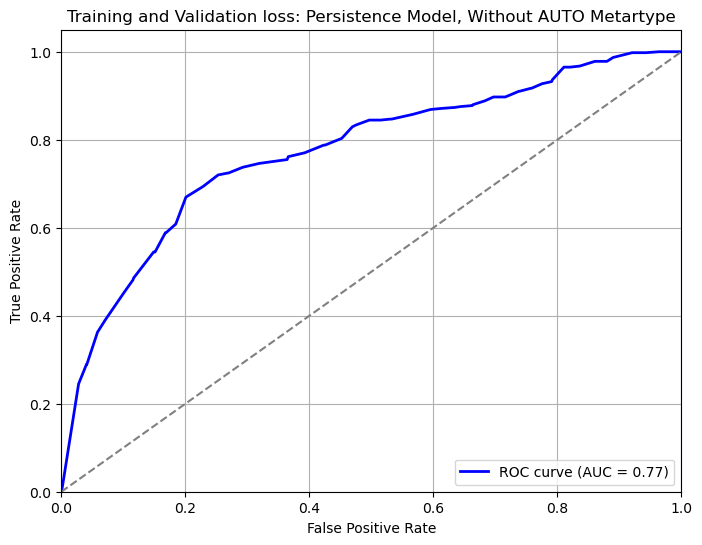

In [40]:

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training and Validation loss: Persistence Model, Without AUTO Metartype')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('rocauc_persistence_model_without_AUTO_.png')
plt.show()

In [1]:
# Save y_pred as csv
#np.save('y_pred_persistence_without_auto.npy', y_pred)

# Save corresponding y_test
#np.save('y_test_persistence_without_auto.npy', y_test)

# Analyzation of data
The code from here and forward is for analyzation purposes. 

In [3]:
y_pred = y_pred.flatten()

NameError: name 'y_pred' is not defined

In [110]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Time': X_test['time'], 'Airport': X_test['airport'], 'Metar': X_test['metar_lead_1'], 'Metartype': X_test['metartype']})

In [111]:
comparison_df.to_csv('comparison.csv', index=False)

In [112]:
pd.set_option('display.max_colwidth', 3000)

In [113]:
comparison_df[comparison_df['Predicted'] > 0.4].head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
506202,False,0.505810,2023-01-18 21:00:00,ENTO,ENTO 182150Z VRB03KT 0150 R18/0700N R36/P2000N BCFG VV001 M01/M01 Q0993=,MANUAL
388861,False,0.991395,2022-10-21 11:00:00,ENRO,ENRO 211150Z 00000KT 9999 BKN002 M02/M03 Q1014=,MANUAL
348455,False,0.949284,2021-03-15 10:00:00,ENOV,ENOV 151120Z VRB02KT 7000 -SHRASN FEW002 SCT010 BKN015 02/M00 Q1010 RMK WIND 2175FT 30011KT=,MANUAL
144019,True,0.941759,2022-11-08 07:00:00,ENDU,ENDU 080820Z 00000KT 0250 R10/0200N R28/0300N FZFG BKN001 M02/M03 Q1006 TEMPO 0400 FZFG SCT001 RMK WIND 1100FT VRB02KT WIND 2200FT 10004KT=,MANUAL
524240,False,0.742348,2022-02-05 04:00:00,ENVA,ENVA 050520Z 22019G30KT CAVOK 03/M06 Q0980 RMK WIND 670FT 22019G37KT=,MANUAL
180990,True,0.618457,2022-12-24 06:00:00,ENGM,ENGM 240650Z 00000KT 0450 R19R/1800D R01R/0600N R19L/0800N R01L/0450N FZFG VV002 M13/M14 Q1008 NOSIG=,MANUAL
47055,True,0.990290,2022-02-10 10:00:00,ENBJ,ENBJ 101050Z 02005KT 0200 FZFG VV002 M04/M04 Q0975 =,MANUAL
144027,True,0.723561,2022-11-08 15:00:00,ENDU,ENDU 081550Z 00000KT 0400 R10/P2000D R28/P2000N FZFG SCT001 M06/M07 Q1007 NOSIG RMK WIND 1100FT 12007KT WIND 2200FT 14011KT=,MANUAL
183018,False,0.856541,2023-03-20 06:00:00,ENGM,ENGM 200720Z 35003KT 320V020 4000 R19R/P2000N R01R/P2000N R19L/1200N R01L/P2000N VCFG SCT002 BKN015 02/02 Q1005 BECMG 9999 NSW SCT020=,MANUAL
3562,False,0.690652,2022-01-21 15:00:00,ENAL,ENAL 240450Z 26018KT 9000 RADZ FEW015 BKN030 04/03 Q1011=,MANUAL


In [114]:
only_true_fz = comparison_df[comparison_df['Actual'] == True]

In [115]:
only_false_fz = comparison_df[comparison_df['Actual'] == False]

In [116]:
only_true_fz.tail(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
173177,True,0.375625,2021-01-19 12:00:00,ENGK,ENGK 191250Z 02007KT 9999 -FZDZ OVC004 M00/M01 Q0997=,MANUAL
303740,True,0.002922,2023-10-24 18:00:00,ENMS,ENMS 241920Z VRB01KT 0900 FZFG VV004 M01/M02 Q1017 RMK WIND 412FT VRB01KT=,MANUAL
173598,True,0.002755,2021-01-10 17:00:00,ENGM,ENGM 101820Z 00000KT 1000 R19R/0700N R01R/P2000N R19L/0900N R01L/P2000N PRFG SCT002 OVC005 M09/M10 Q1008 TEMPO 0500 FZFG VV002=,MANUAL
406187,True,0.883865,2021-11-30 23:00:00,ENRY,ENRY 302350Z VRB01KT 0100NDV R12/0325V0550 R30/0900V1500N FZFG VV000 M11/M12 Q0998=,MANUAL
99752,True,0.000622,2021-01-04 09:00:00,ENBS,ENBS 040950Z 23022KT 9999 -FZRA DRSN FEW045 BKN051 M01/M03 Q1025=,MANUAL
178148,True,0.693331,2022-02-02 23:00:00,ENGM,ENGM 022350Z 00000KT 0650 R19R/0750N R01R/0700D R19L/0650D R01L/1800D FZFG VV002 M11/M12 Q1007=,MANUAL
177045,True,0.999202,2021-12-14 05:00:00,ENGM,ENGM 140620Z 18006KT 0450 R19R/0550N R01R/0500N R19L/0650N R01L/0500U FZFG VV002 M01/M01 Q1012 TEMPO 0800 FZFG=,MANUAL
177393,True,0.039981,2021-12-30 13:00:00,ENGM,ENGM 301420Z 22005KT 1000 R19R/1600N R01R/1200D R19L/1200U R01L/1300U FZFG VV002 M01/M01 Q0992 TEMPO 0700 FZFG=,MANUAL
330097,True,0.977058,2023-10-18 05:00:00,ENNM,ENNM 180620Z 07005KT 0400 R07/0700 FZFG VV002 M01/M01 Q1019=,MANUAL
184367,True,0.915825,2023-11-02 17:00:00,ENGM,ENGM 021750Z 02009KT 6000 -FZRA OVC006 M00/M01 Q0995 TEMPO 4000 -FZDZ BR BKN004=,MANUAL


<AxesSubplot: >

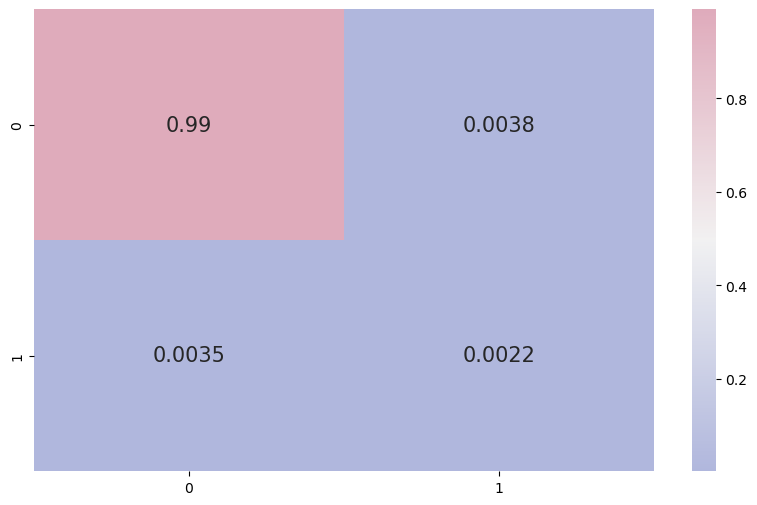

In [117]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

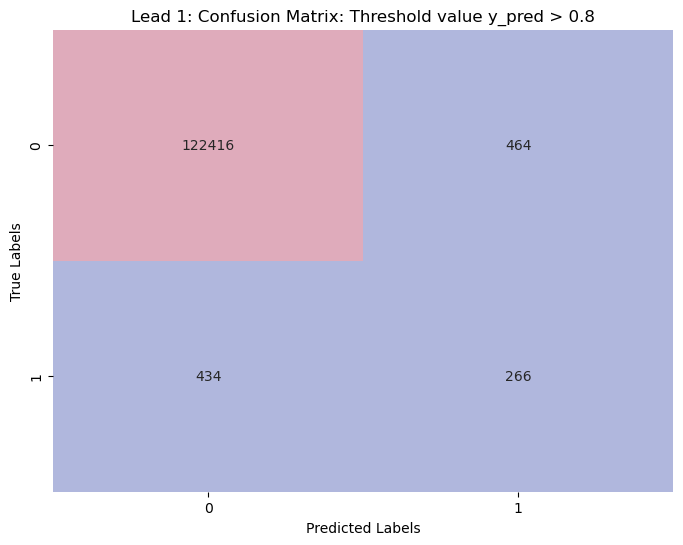

In [118]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap1, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lead 1: Confusion Matrix: Threshold value y_pred > 0.8')
plt.savefig('cmap_0.8.png')
plt.show()

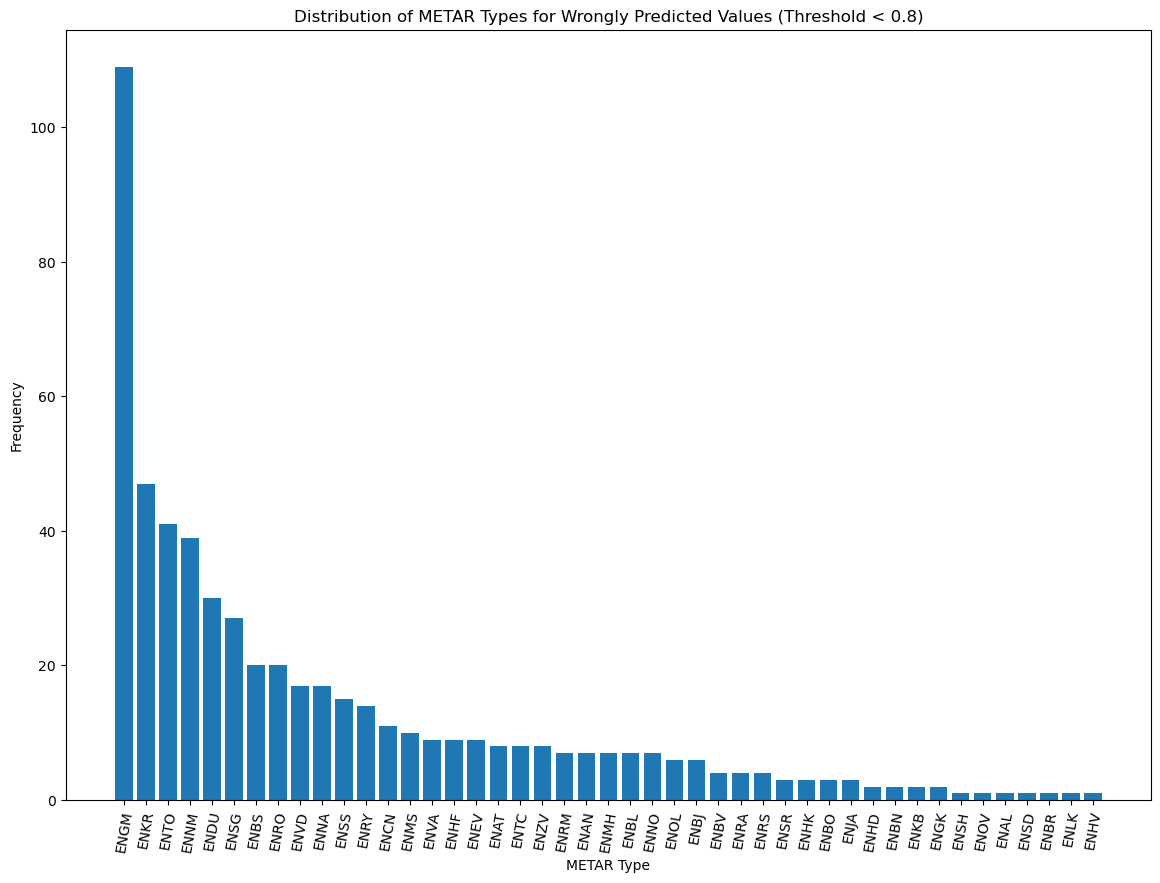

In [119]:
wrongly_predicted_df = only_true_fz[(only_true_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Airport'].value_counts()

plt.figure(figsize=(14, 10))
plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=80)
plt.show()

<Figure size 1400x1000 with 0 Axes>

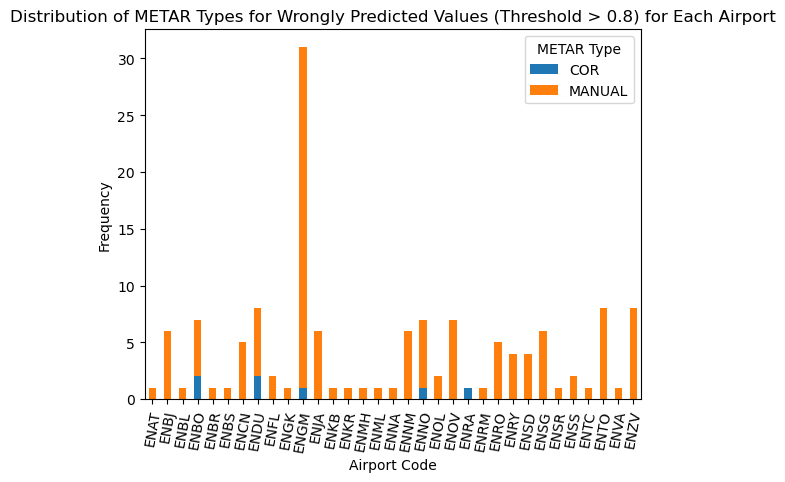

In [121]:
wrongly_predicted_false_df = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.8)]


metar_type_counts_per_airport = wrongly_predicted_false_df.groupby(['Airport', 'Metartype']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 10))  
metar_type_counts_per_airport.plot(kind='bar', stacked=True)
plt.xlabel('Airport Code')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold > 0.8) for Each Airport')
plt.xticks(rotation=80)
plt.legend(title='METAR Type')
plt.show()

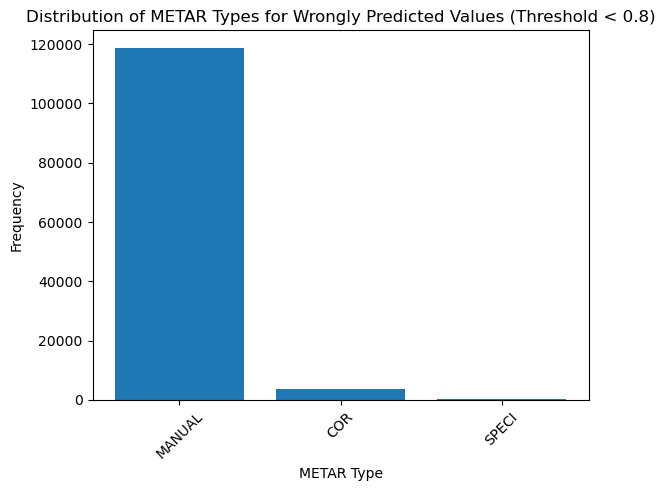

In [122]:
wrongly_predicted_df = only_false_fz[(only_false_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Metartype'].value_counts()

plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=45)
plt.show()

In [123]:
only_false_fz.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
242178,False,2.980412e-03,2023-01-09 07:00:00,ENKB,ENKB 090820Z 08007KT 040V130 CAVOK 08/M03 Q0987 RMK WIND 745FT 12012KT=,MANUAL
51155,False,1.903405e-02,2022-11-18 06:00:00,ENBJ,ENBJ 180650Z 18015KT 9999 BKN017 04/02 Q1019 =,MANUAL
506202,False,5.058103e-01,2023-01-18 21:00:00,ENTO,ENTO 182150Z VRB03KT 0150 R18/0700N R36/P2000N BCFG VV001 M01/M01 Q0993=,MANUAL
351881,False,1.742287e-03,2022-05-26 21:00:00,ENOV,ENOV 262150Z 00000KT 9999 SCT051 05/04 Q1003 RMK WIND RWY24 VRB02KT WIND 2090FT 15012KT=,MANUAL
438719,False,8.545857e-02,2023-05-07 18:00:00,ENSH,ENSH 071850Z 21014KT 5000 -DZRA VV004 05/04 Q1022 RMK WIND 0150FT 20015KT=,MANUAL
1234,False,1.243617e-03,2021-03-03 18:00:00,ENAL,ENAL 031850Z 33009KT 290V360 9999 FEW033 01/M02 Q1026=,MANUAL
526888,False,1.506595e-04,2022-12-15 17:00:00,ENVA,ENVA 151820Z 25006KT 9999 -SN FEW007 BKN012 M02/M03 Q1006 TEMPO 1000 SHSN VV007 RMK WIND 670FT 28010KT=,MANUAL
187593,False,6.851034e-04,2021-04-08 13:00:00,ENHD,ENHD 081350Z 17016KT 7000 RA SCT006 BKN008 05/04 Q0999=,MANUAL
76644,False,6.933064e-04,2023-03-16 10:00:00,ENBN,ENBN 161050Z 16004KT 120V200 9999 FEW030 03/M04 Q1017=,MANUAL
359917,False,9.945087e-04,2021-04-07 14:00:00,ENRA,ENRA 071520Z VRB07KT 4000 -SHSN VV020 M01/M02 Q0998=,MANUAL


### Look at characteristics for wrongly predicted True and False

Check the occurrence of SN and RA for predictions over threshold where contain_FZ = FALSE

In [124]:
wrongly_predicted_true = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.8)]

filtered_wrongly_predicted_true = wrongly_predicted_true[wrongly_predicted_true['Metar'].str.contains(r'\bRA|\bSN')]


In [126]:
filtered_wrongly_predicted_true

,Actual,Predicted,Time,Airport,Metar,Metartype
173848,False,0.804119,2021-01-21 03:00:00,ENGM,ENGM 210350Z 06002KT 8000 -RASN OVC003 00/00 Q0981=,MANUAL
145707,False,0.986407,2023-01-22 00:00:00,ENDU,ENDU 220050Z 19009KT 130V260 9999 -RA FEW020 BKN035 04/00 Q1017 RMK WIND 1100FT 20028KT WIND 2200FT 21027KT=,MANUAL
45073,False,0.932699,2021-11-17 21:00:00,ENBJ,ENBJ 172150Z 10025KT 3000 RA OVC006 02/01 Q0991=,MANUAL
174564,False,0.981577,2021-02-20 00:00:00,ENGM,ENGM 200120Z 18004KT 1900 -SNRA BR VV003 00/00 Q1009=,MANUAL
260240,False,0.914708,2023-05-18 05:00:00,ENKR,ENKR 180550Z 03013KT 9999 -RASN OVC004 02/01 Q1009 RMK WIND 731FT 03027G38KT=,MANUAL
233656,False,0.978897,2022-03-03 15:00:00,ENJA,ENJA 040550Z 07019KT 5000 SNRA BKN005 01/00 Q0994=,MANUAL
471312,False,0.924237,2023-03-30 09:00:00,ENSS,ENSS 300950Z 14009KT 2100 -SN FEW006 BKN012 M02/M02 Q0998 RMK WIND 0500FT 13007KT=,MANUAL
428449,False,0.948717,2023-03-13 18:00:00,ENSG,ENSG 131920Z 07002KT 9999 R24///// -SN FEW/// SCT004 BKN034 M04/M05 Q0969 RMK WIND 3806FT 05006KT=,MANUAL
418901,False,0.988602,2022-12-30 17:00:00,ENSD,ENSD 301750Z 08007KT 010V180 9999 -RA BKN030 05/01 Q0975 RMK WIND RWY26 VRB05KT WIND 1140FT VRB04G20KT=,MANUAL
499228,False,0.885472,2021-01-19 19:00:00,ENTO,ENTO 191950Z 36005KT 1200 R18/P2000N R36/P2000N SN VV003 M01/M01 Q0998 TEMPO 3000 -SN BR OVC005=,MANUAL


Look at characteristics for wrongly predicted false

In [97]:
wrongly_predicted_false = comparison_df[(comparison_df['Actual'] == True) & (comparison_df['Predicted'] <= 0.4)]

filtered_wrongly_predicted_false = wrongly_predicted_false[wrongly_predicted_false['Metar'].str.contains(r'\bRA|\bSN')]


In [99]:
filtered_wrongly_predicted_false.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
517321,True,1.794793e-02,2023-03-05 12:00:00,ENUG,ENUG 051250Z 29017KT 270V340 0550NDV +SN NCD M05/M07 Q1000 REFZRA W///S4=,AUTO
215814,True,1.400332e-01,2023-02-11 01:00:00,ENHK,ENHK 110150Z 26023G35KT 3600 -SN FEW010/// SCT046/// M02/M05 Q0989 REFZDZ=,AUTO
277596,True,1.424869e-01,2022-12-27 09:00:00,ENMH,ENMH 270950Z 19026KT 9999 -SN NCD M01/M03 Q0994 REFZDZ=,AUTO
243765,True,2.549322e-03,2023-03-26 06:00:00,ENKB,ENKB 260720Z VRB03KT 9999 -SN FEW005/// SCT012/// BKN021/// M02/M06 Q1002 REFZUP RMK WIND 745FT 20008KT=,AUTO
391373,True,2.672997e-01,2023-02-09 02:00:00,ENRO,ENRO 090250Z 19014G25KT 160V220 9999 -SN OVC029/// 02/M03 Q0997 REFZRA=,AUTO
519886,True,1.190089e-03,2021-01-23 09:00:00,ENVA,ENVA 230950Z 12005KT 9999 -FZDZ SCT009 OVC072 M02/M03 Q0979 TEMPO 2000 SN VV008 RMK WIND 670FT 15003KT=,MANUAL
517454,True,2.028487e-01,2023-03-11 01:00:00,ENUG,ENUG 110220Z 24026G40KT 6000NDV -SN FEW010/// BKN020/// BKN046/// M02/M05 Q0980 REFZRA W///S6=,AUTO
469996,True,1.110962e-03,2023-02-02 13:00:00,ENSS,ENSS 021350Z 36004KT 2000 -SN SCT009/// BKN032/// OVC048/// M03/M05 Q1009 REFZDZ RMK WIND 0500FT VRB10KT=,MANUAL
400836,True,4.912246e-03,2023-03-20 22:00:00,ENRS,ENRS 202320Z 25022KT 9999 -SN FEW006/// SCT024/// BKN042/// 01/M04 Q0999 REFZRA=,AUTO
173791,True,2.834710e-03,2021-01-18 18:00:00,ENGM,ENGM 181920Z 01003KT 1000 R19R/1600D R01R/0900N R19L/1300D R01L/1200N FZFG VV003 M06/M07 Q1007 TEMPO 2000 -SN BR=,COR
